In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/clay/userdata/title_generation


In [6]:
import argparse
from pathlib import Path
from typing import Union
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence
import matplotlib.pyplot as plt

from data_utils import pack_collate, ABCsetTitle, MeasureOffsetSet
from trainer import Trainer, TrainerPitchDur
from model_zoo import MeasureInfoModel
from emb_loss import get_batch_contrastive_loss
from emb_trainer import EmbTrainer

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--path', type=str, default='dataset/the_session/',
                    help='directory path to the dataset')
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--num_epochs', type=int, default=10)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--hidden_size', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=3)
parser.add_argument('--dropout', type=float, default=0.1)
parser.add_argument('--num_workers', type=int, default=2)
parser.add_argument('--device', type=str, default='cuda')
parser.add_argument('--vocab_path', type=str, default='dataset/the_session/measure_info_vocab.json')

#parser.add_argument('--model_type', type=str, default='pitch_dur')
parser.add_argument('--save_dir', type=Path, default=Path('experiments/'))

args = parser.parse_args('')

In [8]:
score_dir = Path(args.path)

dataset_meas = MeasureOffsetSet(score_dir, args.vocab_path)
dataset_ttl = ABCsetTitle(score_dir, args.vocab_path)

ValueError: min() arg is an empty sequence

In [16]:
len(dataset_meas.tune_list)

34274

In [15]:
dataset_ttl[3]

(tensor([[  1,   0,   1,   1,  23,   7,   3,  10],
         [112,  10,   3,   3,  23,   7,   3,  10],
         [  3,   0,   3,  27,  23,   7,   3,  10],
         [112,   7,   3,  27,  23,   7,   3,  10],
         [108,   7,   3,  32,  23,   7,   3,  10],
         [  3,   0,   3,  37,  23,   7,   3,  10],
         [110,  10,   3,  37,  23,   7,   3,  10],
         [  3,   0,   3,  47,  23,   7,   3,  10],
         [110,   7,   3,  47,  23,   7,   3,  10],
         [115,   7,   3,  51,  23,   7,   3,  10],
         [140,   0,   3,  56,  23,   7,   3,  10],
         [112,   7,   4,   3,  23,   7,   3,  10],
         [110,   7,   4,   8,  23,   7,   3,  10],
         [112,   7,   4,  27,  23,   7,   3,  10],
         [115,   7,   4,  32,  23,   7,   3,  10],
         [  3,   0,   4,  37,  23,   7,   3,  10],
         [117,   7,   4,  37,  23,   7,   3,  10],
         [119,   7,   4,  42,  23,   7,   3,  10],
         [120,   7,   4,  47,  23,   7,   3,  10],
         [115,   7,   4,  51,  

In [28]:
i = 0
for i in range(len(dataset_ttl.filtered_tunes_list_avail)):
  if dataset_ttl.filtered_tunes_list_avail[i][0].title != dataset_ttl.title_in_text_avail[i]:
    print('something wrong')
dataset_ttl.filtered_tunes_list_avail[i][0].title, dataset_ttl.title_in_text_avail[i]

("Whinham's", "Whinham's")

In [5]:
model = MeasureInfoModel(dataset_meas.vocab.get_size(), args.hidden_size)
#model = torch.load('melody_lm_best.pt')
model.load_state_dict(torch.load('melody_lm_best_meas.pt')['model'])
model.eval()

MeasureInfoModel(
  (emb): MultiEmbedding(
    (layers): ModuleList(
      (0): Embedding(154, 256)
      (1): Embedding(21, 256)
      (2): Embedding(138, 128)
      (3): Embedding(61, 128)
      (4): Embedding(26, 64)
      (5): Embedding(10, 64)
      (6): Embedding(4, 64)
      (7): Embedding(16, 64)
    )
  )
  (rnn): GRU(1024, 256, num_layers=3, batch_first=True, dropout=0.1)
  (proj): Linear(in_features=256, out_features=175, bias=True)
)

In [6]:
rnn_trans = nn.GRU(int(args.hidden_size * 4), args.hidden_size, num_layers=3, batch_first=True, dropout=0.1)
rnn_trans.load_state_dict(model.rnn.state_dict())

<All keys matched successfully>

In [7]:
class MultiEmbedding(nn.Module):
  def __init__(self, vocab_sizes: Union[list, tuple], embedding_sizes: Union[int, list, tuple]) -> None:
    super().__init__()
    self.layers = []
    if isinstance(embedding_sizes, int):
      embedding_sizes = [embedding_sizes] * len(vocab_sizes)
    for vocab_size, embedding_size in zip(vocab_sizes, embedding_sizes):
      self.layers.append(nn.Embedding(vocab_size, embedding_size))
    self.layers = nn.ModuleList(self.layers)

  def forward(self, x):
    return torch.cat([module(x[..., i]) for i, module in enumerate(self.layers)], dim=-1)

In [8]:
emb_trans = MultiEmbedding(dataset_meas.vocab.get_size(), [args.hidden_size, 
                                                      args.hidden_size, 
                                                      args.hidden_size//2, 
                                                      args.hidden_size//2,
                                                      args.hidden_size//4,
                                                      args.hidden_size//4,
                                                      args.hidden_size//4,
                                                      args.hidden_size//4])

In [9]:
emb_trans.load_state_dict(model.emb.state_dict())

<All keys matched successfully>

In [10]:
class ABC_meas_emb_Model(nn.Module):
  def __init__(self, vocab_size, hidden_size=128, emb_size=128):
    super().__init__()
    self.vocab_size = vocab_size
    self.hidden_size = hidden_size
    self.emb = emb_trans
    self.rnn = rnn_trans
    self.proj = nn.Linear(self.hidden_size, emb_size)
    
  def forward(self, input_seq):
    if isinstance(input_seq, PackedSequence):
      emb = PackedSequence(self.emb(input_seq[0]), input_seq[1], input_seq[2], input_seq[3])
      hidden, last_hidden = self.rnn(emb)
      hidden_emb = last_hidden.data[-1] # 1 x 256
      final_emb = self.proj(hidden_emb) # 1 x 128
      
    return final_emb

In [11]:
ABC_emb_model = ABC_meas_emb_Model(dataset_meas.vocab.get_size(), args.hidden_size, emb_size=128)

In [47]:
len(dataset_ttl) # len size가 data_loader와 관련이 있을까?

15382

In [12]:
trainset, validset = torch.utils.data.random_split(dataset_ttl, [int(len(dataset_ttl)*0.9), len(dataset_ttl) - int(len(dataset_ttl)*0.9)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(trainset, batch_size=args.batch_size, collate_fn=pack_collate, shuffle=True) #collate_fn=pack_collate)
valid_loader = DataLoader(validset, batch_size=args.batch_size, collate_fn=pack_collate, shuffle=False) #collate_fn=pack_collate)


In [13]:
sample = next(iter(train_loader))
ABC_emb_model(sample[0]).shape

torch.Size([32, 128])

In [14]:
class TTLembModel(nn.Module): 
    def __init__(self, in_embedding_size=384, hidden_size=256, out_embedding_size=128):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(in_embedding_size, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, out_embedding_size) 
                                    )
        
    def forward(self, x):
        '''
        x (torch.FloatTensor): N x Feature
        '''
        return self.layer(x)

In [15]:
batch_size = 32

# model1 = ABCembModel(len(dataset.vocab)).to('cuda')
model1 = ABC_pidu_emb_Model(dataset_pidu.vocab.get_size(), args.hidden_size, emb_size=128).to('cuda')
model2 = TTLembModel().to('cuda')

optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4)

loss_fn = get_batch_contrastive_loss

trainset, validset = torch.utils.data.random_split(dataset_ttl, [int(len(dataset_ttl)*0.9), len(dataset_ttl) - int(len(dataset_ttl)*0.9)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(trainset, batch_size=args.batch_size, collate_fn=pack_collate_title, shuffle=True) #collate_fn=pack_collate)
valid_loader = DataLoader(validset, batch_size=args.batch_size, collate_fn=pack_collate_title, shuffle=False) #collate_fn=pack_collate)

trainer = EmbTrainer(model1, model2, optimizer1, optimizer2, loss_fn, train_loader, valid_loader, device='cuda')

NameError: name 'ABC_pidu_emb_Model' is not defined

In [23]:
trainer.train_by_num_epoch(50)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation loss: Epoch 1, Loss: 0.4986 


  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation loss: Epoch 2, Loss: 0.4947 


  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation loss: Epoch 3, Loss: 0.4845 


  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation loss: Epoch 4, Loss: 0.4589 


  0%|          | 0/3 [00:00<?, ?it/s]

Saving the model with best validation loss: Epoch 5, Loss: 0.4480 


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

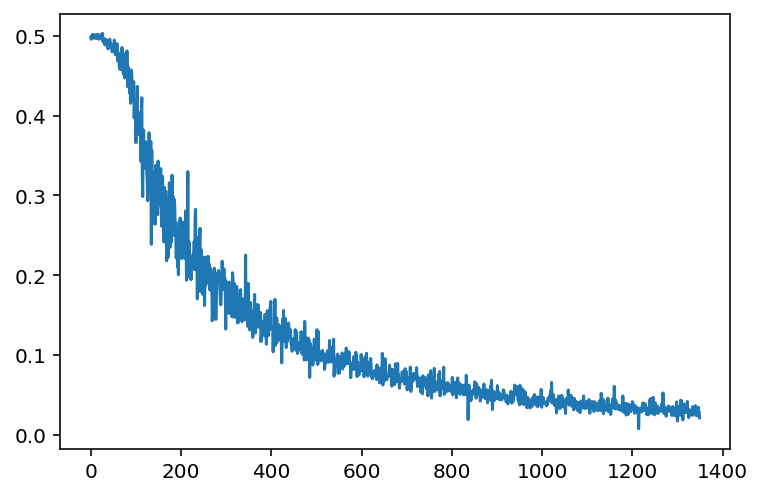

In [25]:
plt.plot(trainer.training_loss)

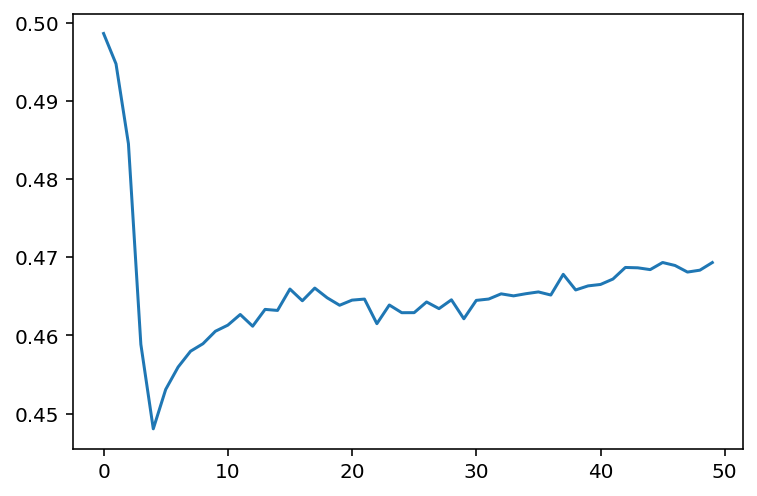

In [26]:
plt.plot(trainer.validation_loss)

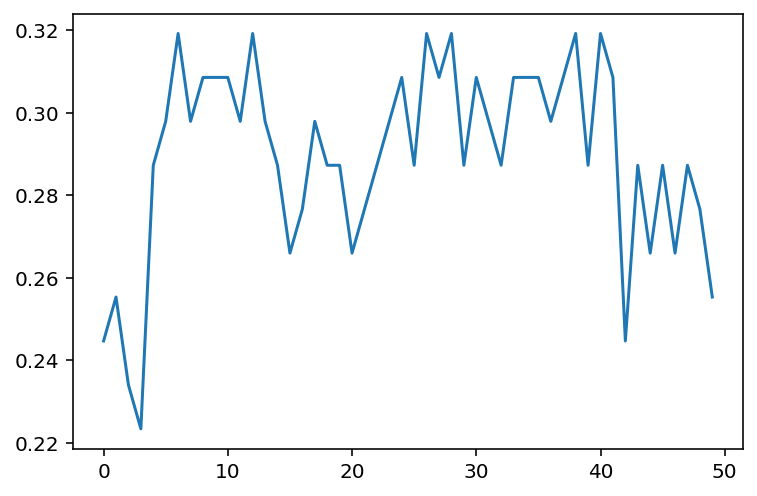

In [27]:
plt.plot(trainer.validation_acc)